First we begin with some import statements. These will load the python packages we need  

We are going to need:  
**pandas** for datastructures  
**numpy** for simple linear algebra and mathematical tricks  
**matplotlib** for plotting  
**scikit-learn** for svm. 
**keras** for machine learning. 
**tensorflow** for machine-learning backing with keras. 


In [4]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
from sklearn.model_selection import GridSearchCV
#import matplotlib.pyplot as plt
from pprint import pprint
import tensorflow as tf
from tensorflow import keras

# Introduction

With the following exercise we will build neural networks to expand the analysis of the previous two
exercises on linear models and kernel machines.   
  
The exercise uses the Keras library, which includes various routines and methods for formulating deep learning models.   
Keras runs on top of various frameworks such as Tensorflow or the Microsoft Cognitive Toolkit.  
Here we will use the default framework, TensorFlow.  
  
The library supports both CPU and GPU implementations, but we will restrict our computations to the CPU, i.e. the data we consider is limited in size. That being said, the exercise provides a good background to get started with the analysis of more complex problems.

# Data

In addition to the big five items in the previous exercise, we now consider an enlarged questionnaire dataset
with additional items addressing non-personality subjects such as spare time activities, relation to family
embers etc. In total there are now **271** items (instead of only the 43) in addition to the gender variable.  
With this number of variables, the convergence of the linear model becomes an issue, and some feature engineering would be needed. In
contrast, the “engineering” part is avoided using the deep learning model.  
  
Before we start with the learning part, we have to scale our data and pick out proper training, validation and test
sets.

In [5]:
### Load, scale and fix data
dat1 = pd.read_table('RGender_all_filt.dat', delimiter=' ')              # Load
#dat1 = dat1.transpose()
dat1_scaled = dat1 / dat1.max()                                 # Scale
dat1_scaled = dat1_scaled.where(dat1_scaled >= 0, other = -1);  # Only get answers above or equal to 0, everything else set to -1

In [6]:
### Make a feature and target dataframe
answers = dat1_scaled.iloc[:,1::]                   # Make a DataFrame "answers" as a copy of all the data but without the gender column (The 0'th col)
gender  = dat1_scaled.iloc[:,0:1]                   # Copy gender to its own variable (We are going to try and predict this one)

Once the data is cured and ready, we load the Keras library and convert the data to a structure readable by
Keras

In [7]:
### Make training and validation sets
m = range(len(answers)) # 0,1,2,3,...,n - where n is the number of answers
np.random.seed(42)  # Create a seed so we can compare with other runs who run the program
svm_learn_idx, svm_valid_idx = sklearn.model_selection.train_test_split( m , test_size = 0.25) # shuffle m into learning and validation set.
x_learn = answers.iloc[svm_learn_idx] # Answers
x_valid = answers.iloc[svm_valid_idx] # Answes
y_learn = gender.iloc[svm_learn_idx]  # Gender
y_valid = gender.iloc[svm_valid_idx]  # Gender

# Building a neural network in Keras

The power of Keras is the simplicity by which models are constructed. We define a model in terms of a
sequential stack of layers which together form our neural network.  
  
The construction of the network is like building with LEGO bricks, where the individual layers in the network
correspond to the bricks.  
Each time we add a new brick or layer it is added on top of
the existing network. The network below have 3 layers.

In [8]:
### Make model

from tensorflow.keras.layers import Dropout
model = keras.models.Sequential()
n = x_learn.shape[1]
model.add(keras.layers.Dense(8, activation='relu', input_shape=(n,)))
model.add(Dropout(0.4))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(keras.layers.Dense(1, activation='sigmoid'))

ModuleNotFoundError: No module named 'keras'

Here the model is build by first adding a dense layer with 16 units, then a dense layer with 4 units and finally
a dense layer of a single unit. A layer is said to be dense, if every entry in the input to a layer connects to all
units in that layer. Details about the model can be seen by

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 2176      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


A simple model like this end up with a huger number of parameters! It really shows that there always
is a latent risk for over-fitting.  
  
Next, we compile the model and specify which loss function should be used to evaluate the quality of the
network output. We also specify the optimization algorithm used to train our network.

In [8]:
### Compile model
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Finally, we train our our model (or fit) calling the fit function. The fit function takes as input a number
of variables, such as the number of training runs (epochs), the batch size for each training round and a
validation set (here specified to be 30% randomly selected from the data.

In [9]:
## Run model
hist = model.fit(x_learn, y_learn, batch_size=36, epochs=100, validation_split=0.2, verbose=0);

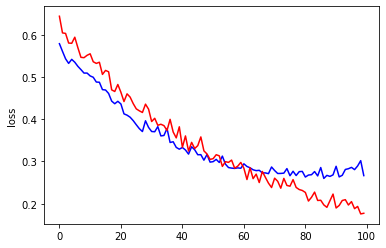

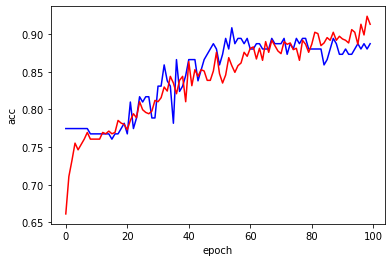

In [10]:
plt.figure()
plt.plot(hist.history['val_loss'], 'b')
plt.plot(hist.history['loss'], 'r')
plt.ylabel('loss')

plt.figure()
plt.plot(hist.history['val_accuracy'], 'b')
plt.plot(hist.history['accuracy'], 'r')
plt.ylabel('acc')
plt.xlabel('epoch');

In [11]:
### Use model to predict
print(model.evaluate(x_valid, y_valid))
print(model.metrics_names) # We are interested in the accuracy score here. 
# You can read about loss here: https://keras.io/losses/ 
# & https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss
# & https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model

8/8 [==============================] - 0s 2ms/step - loss: 0.5026 - accuracy: 0.8475
[0.5025979280471802, 0.8474576473236084]
['loss', 'accuracy']


In [12]:
### See prediction
prediction = (model.predict(x_valid) > 0.5)
prediction[0:10]

array([[False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True]])

In [13]:
### Compare it yourself with actual target
actual = y_valid != 0
actual[0:10]

,gender
u335,False
u585,True
u852,True
u372,True
u31,False
u523,False
u733,True
u823,True
u24,True
u880,True


In [14]:
#from __future__ import print_function
#import keras
from keras.datasets import mnist
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if tf.keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11501568/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/4
469/469 [==============================] - 68s 143ms/step - loss: 2.3058 - accuracy: 0.0983 - val_loss: 2.2951 - val_accuracy: 0.1033
Epoch 2/4
469/469 [==============================] - 62s 131ms/step - loss: 2.2942 - accuracy: 0.1116 - val_loss: 2.2821 - val_accuracy: 0.1280
Epoch 3/4
469/469 [==============================] - 64s 137ms/step - loss: 2.2817 - accuracy: 0.1277 - val_loss: 2.2684 - val_accuracy: 0.1515
Epoch 4/4
469/469 [==============================] - 65s 139ms/step - loss: 2.2682 - accuracy: 0.1455 - val_loss: 2.2525 - val_accuracy: 0.1950
Test loss: 2.2524991035461426
Test accuracy: 0.19499999284744263
